In [1]:
# depth_plots.ipynb
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from os import listdir, walk, getcwd
from os.path import isfile, join
import json

In [72]:
# load and seaparate data
filename = "csinet-lstm-depth.csv"
df = pd.read_csv(filename, header=0)
df.head()

,Network,CR,Depth,Envir,1,2,3,4,5,6,7,8,9,10
0,CsiNet-LSTM,1/16,3,Indoor,-23.182717,-24.191021,-22.661356,-22.235306,-22.373432,-22.789792,-22.637391,-22.934971,-22.397693,-22.637939
1,CsiNet-LSTM,1/32,3,Indoor,-23.544245,-23.756598,-22.473414,-22.808458,-22.915300,-22.860528,-22.798098,-22.476187,-22.634861,-22.484778
2,CsiNet-LSTM,1/64,3,Indoor,-24.717457,-19.599669,-19.902439,-19.580526,-19.262702,-19.459482,-19.316281,-19.620172,-19.358209,-19.515092
3,CsiNet-LSTM,1/16,3,Outdoor,-7.108988,-7.125139,-6.276524,-6.596075,-6.550933,-6.470424,-6.343503,-6.342081,-6.187878,-6.072491
4,CsiNet-LSTM,1/32,3,Outdoor,-7.583949,-7.029225,-6.508884,-5.963317,-5.555296,-5.290221,-5.121099,-5.032453,-4.981925,-5.003562


In [77]:
def plot_tests(df,depth,envir,ylabel="Test Loss [NMSE]"):
    save_bool = False
    plt.style.use(['science','ieee','muted'])
    df_target = df[(df["Envir"]==envir) & (df["Depth"]==depth)]
    n_tests, n_col = df_target.shape
    fig, ax = plt.subplots(figsize=(4,3))
    t_vals = [i for i in range(1,11)]
    t_labels = [r"$t_{{{:2d}}}$".format(i) for i in range(1,11)]
    for idx, row in df_target.iterrows():
        vals = [row["{}".format(i)] for i in range(1,11)]
        label = "CR={}".format(row["CR"]) if (type(row["CR"]) == type("hello")) else "{}".format(row["Network"])            
        ax.plot(t_vals, vals, label=label)
    ax.set(ylabel=ylabel)
    ax.grid()
    ax.legend()
    plt.xticks(t_vals)
    ax.set_xticklabels(t_labels)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.15), ncol=4, fontsize="x-small")
    plt.show()
    fig_name="{}_D{}.eps".format(envir,depth)
    fig.savefig(fig_name)

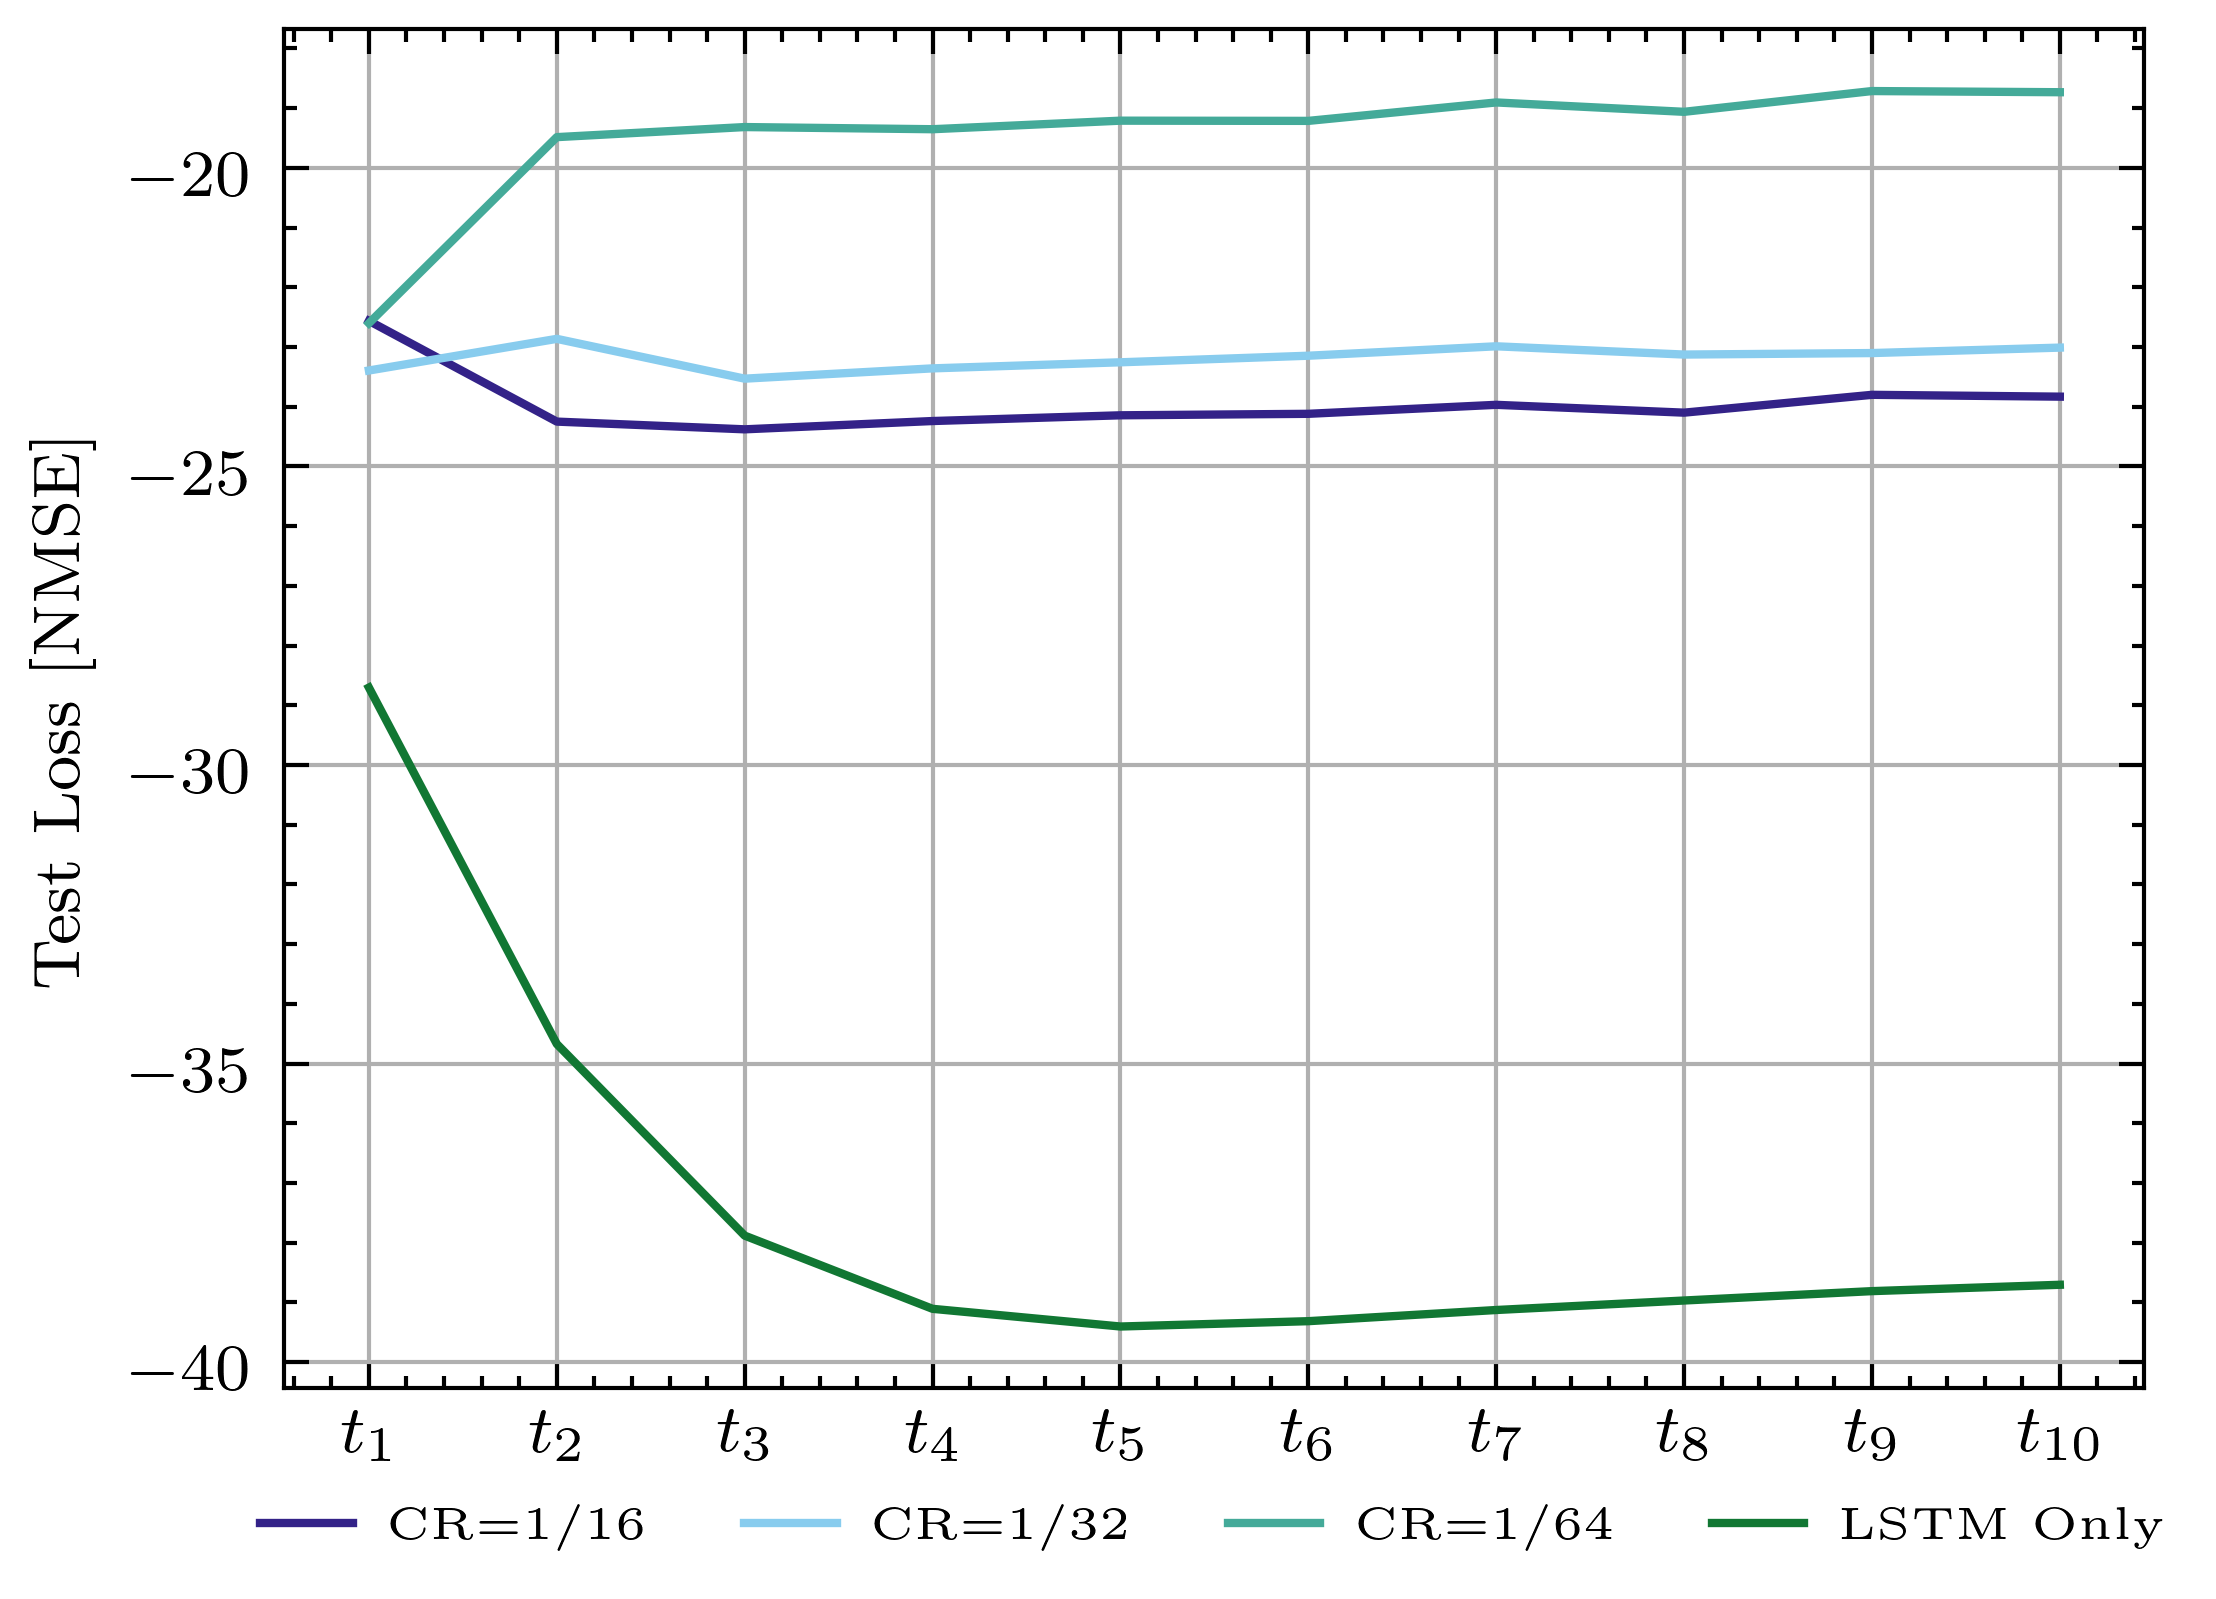

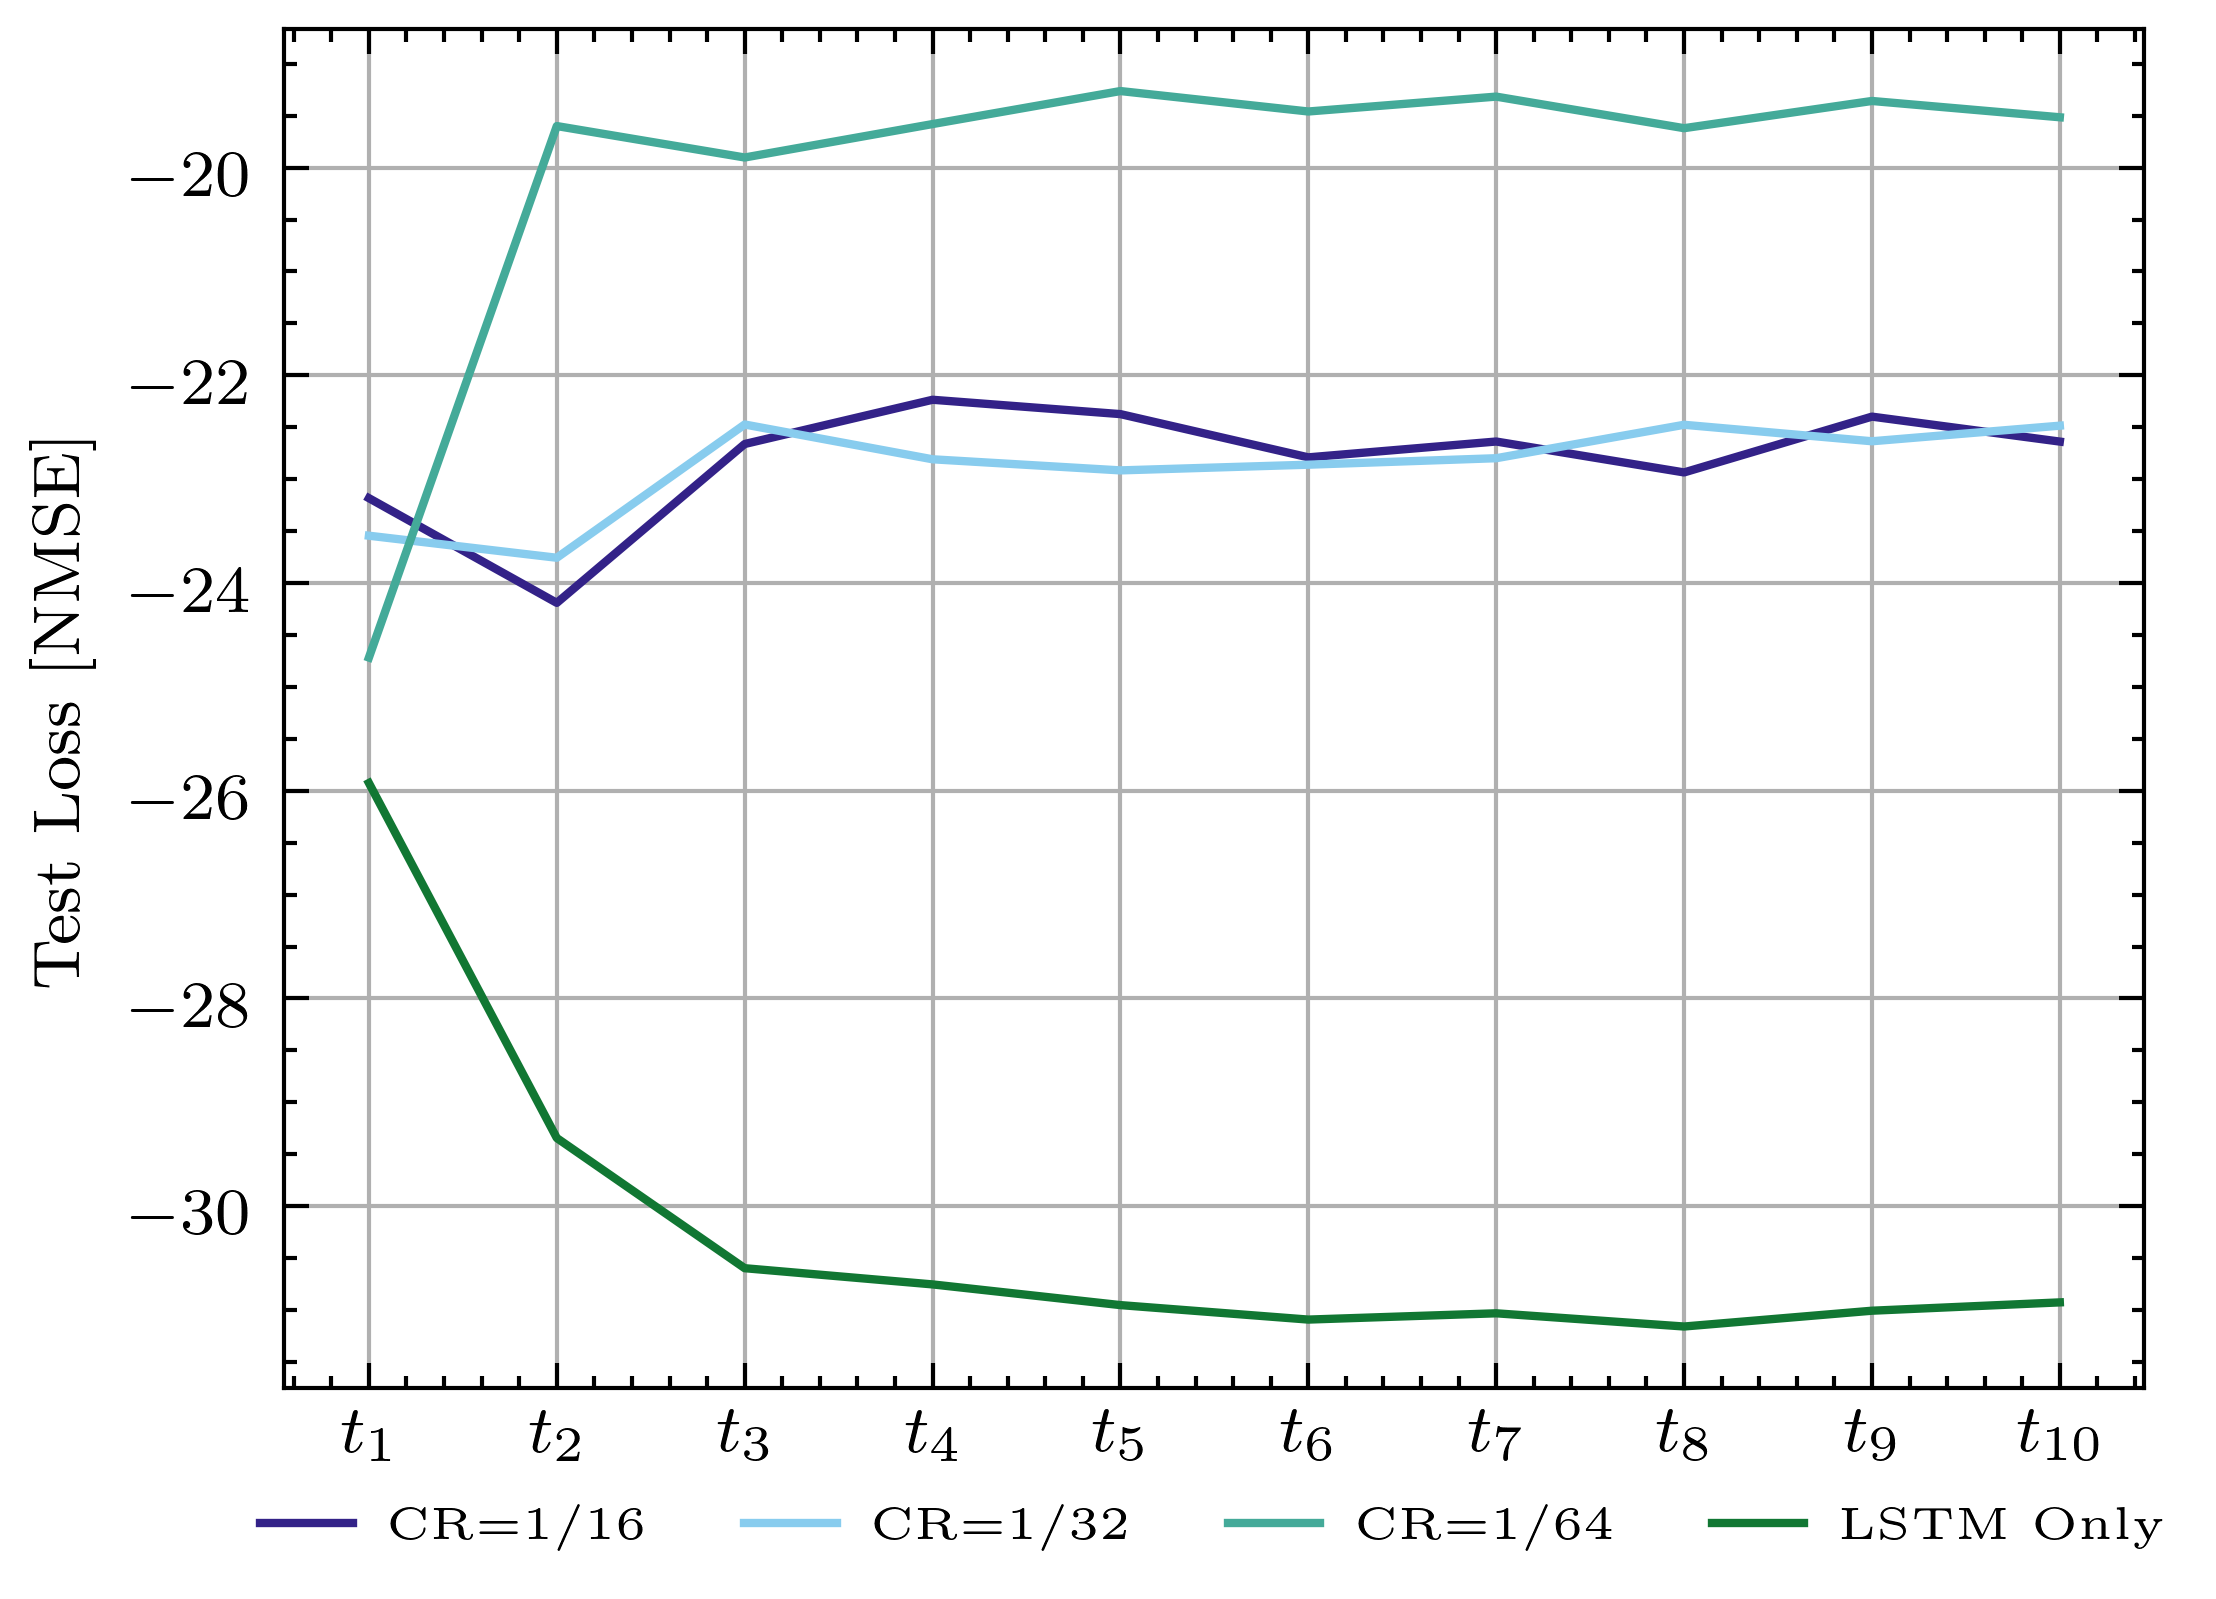

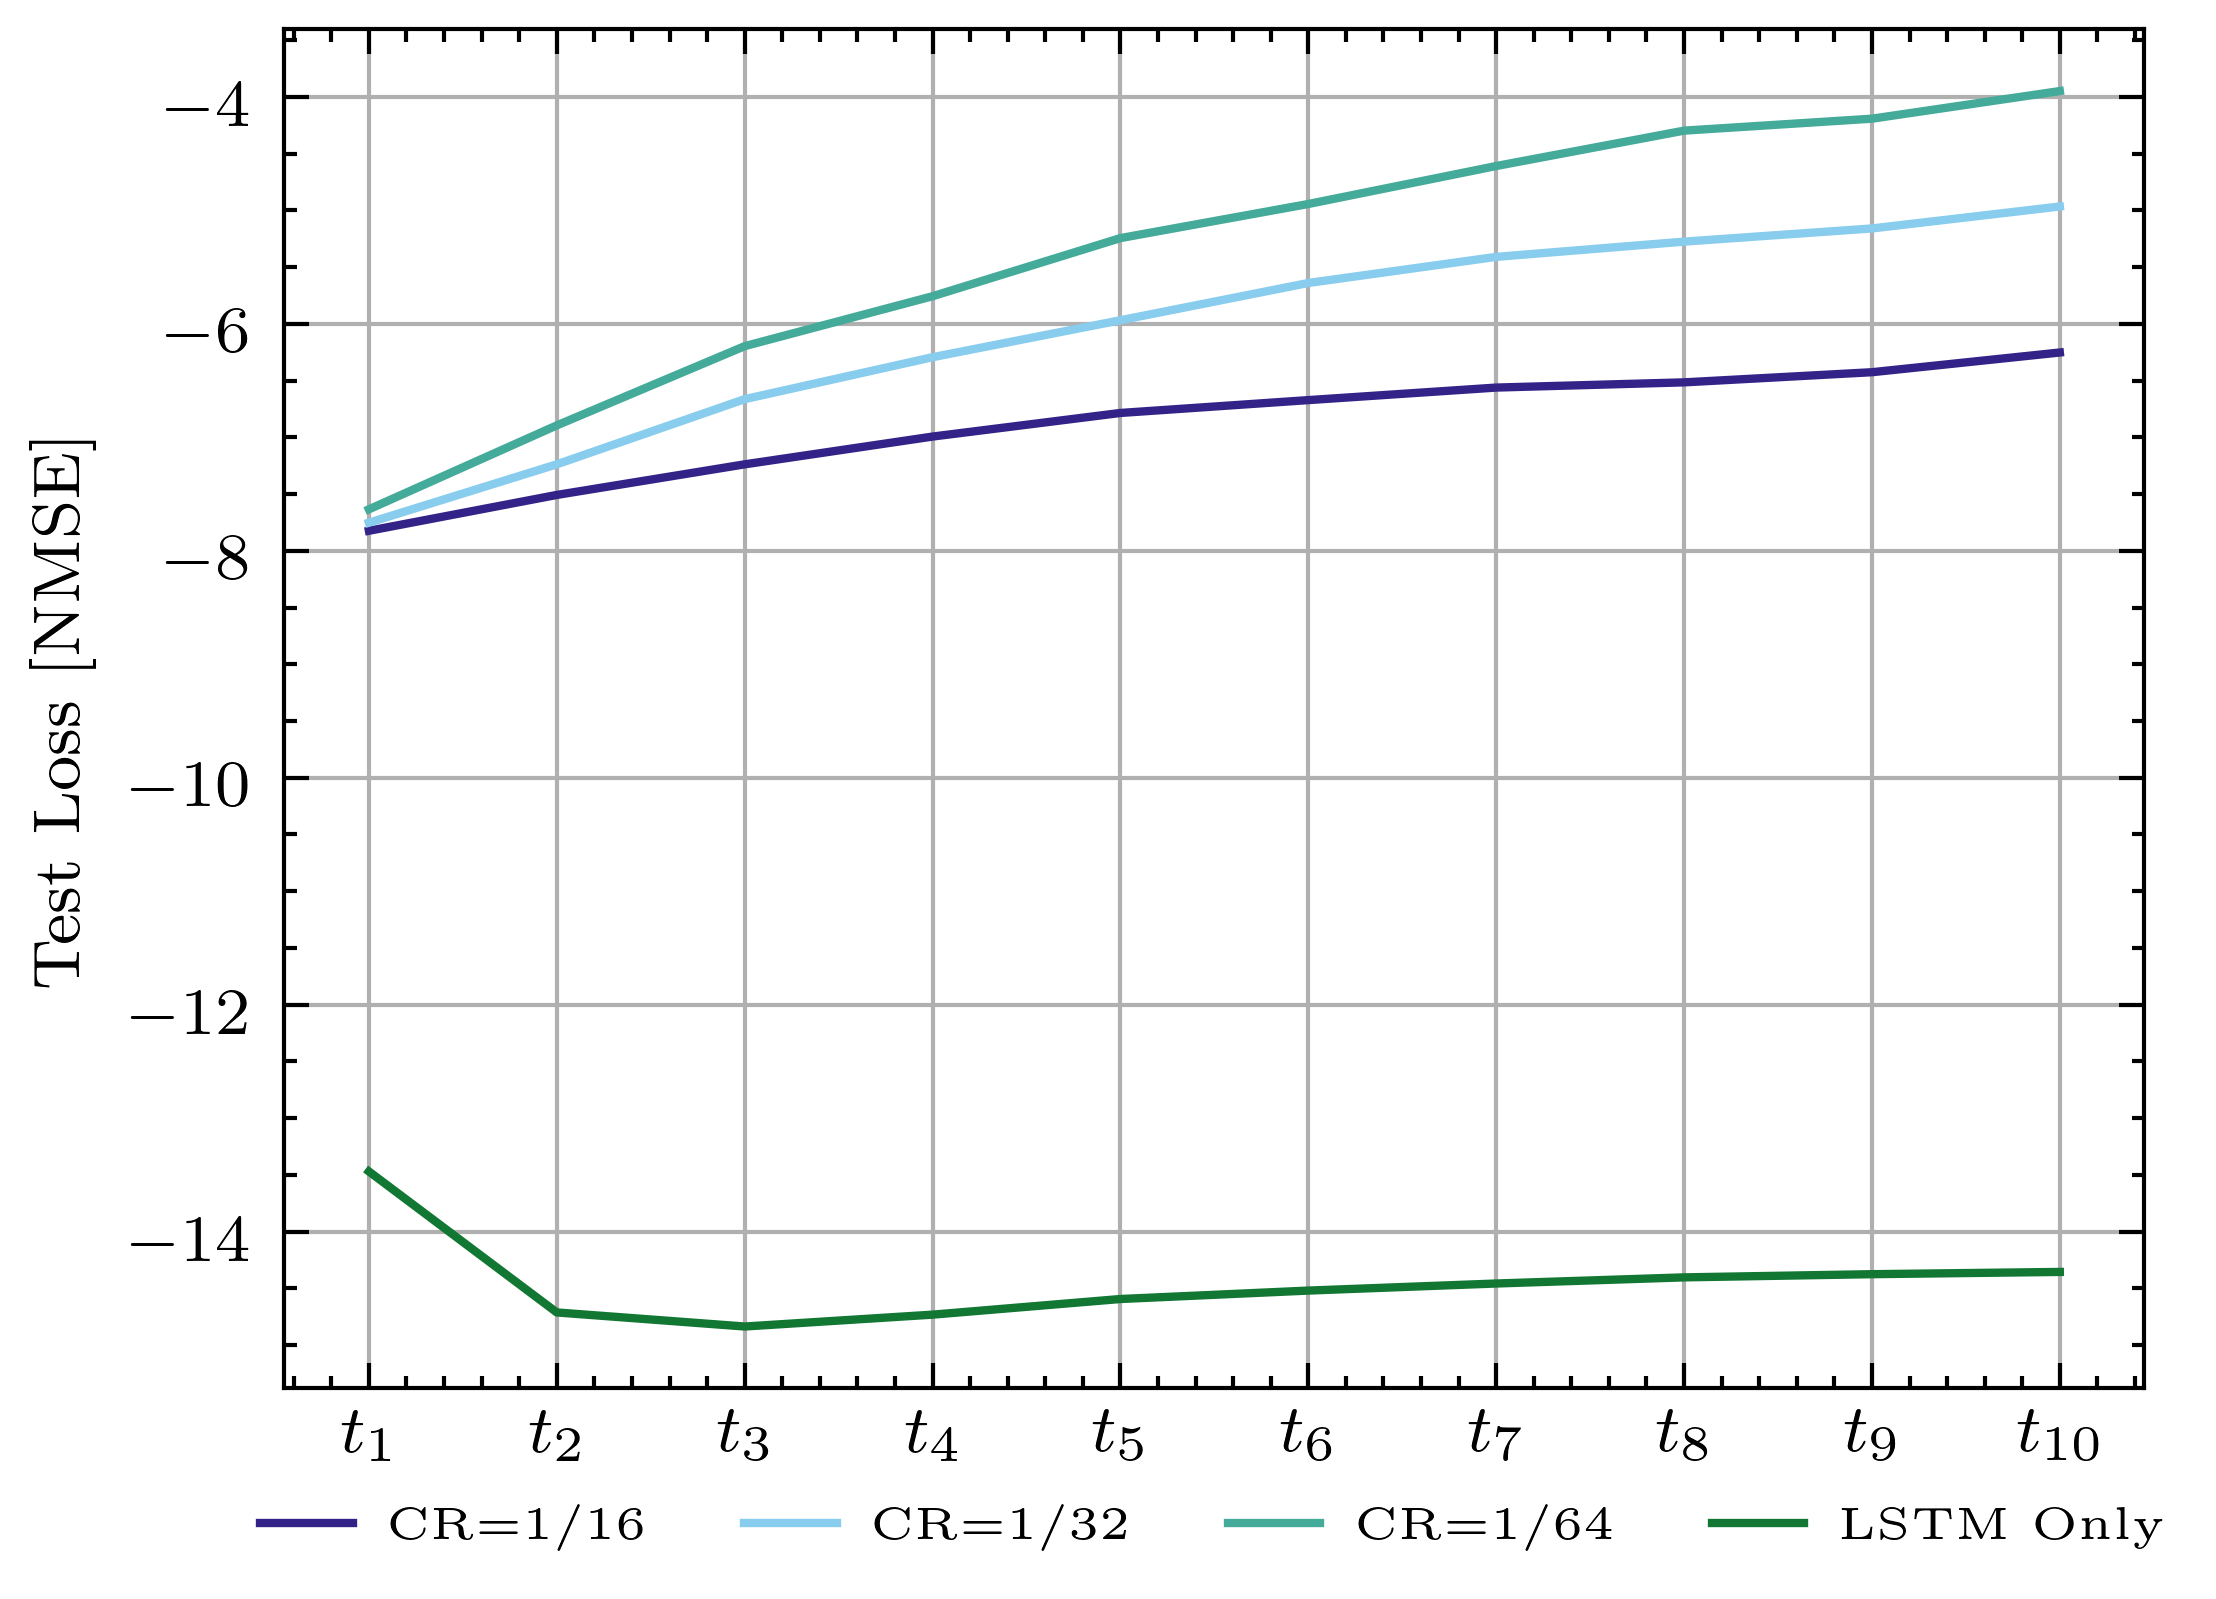

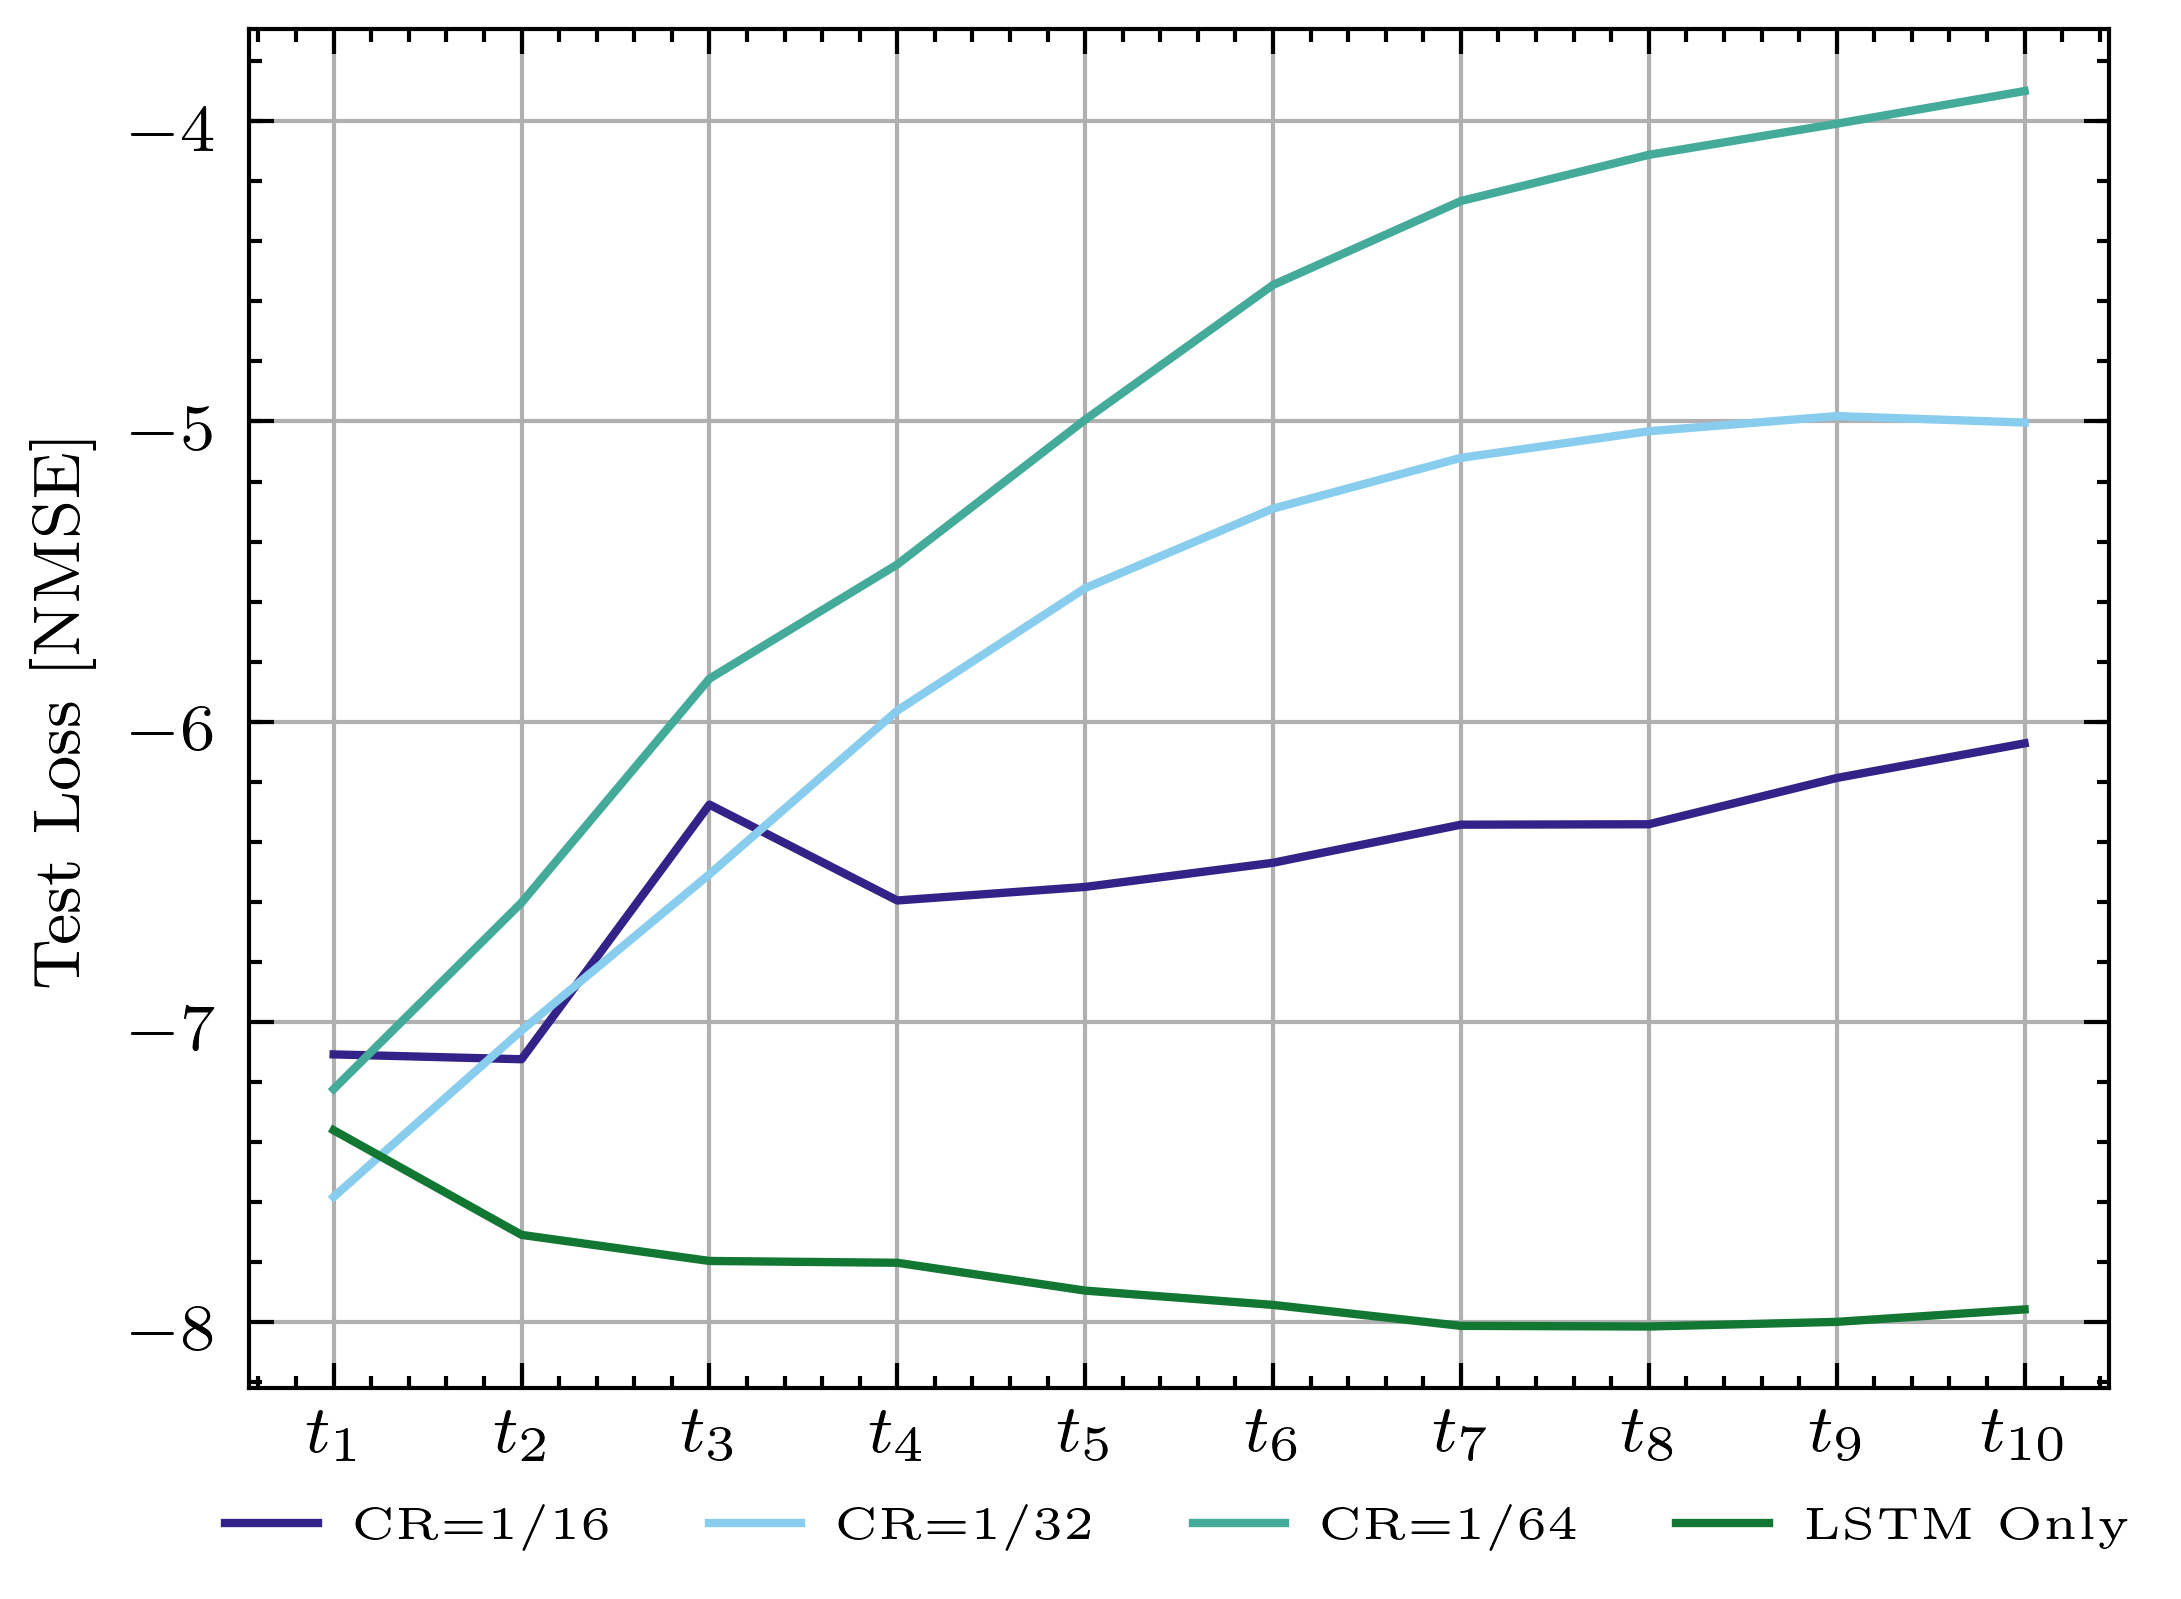

In [78]:
depths=[1,3]
envirs=["Indoor","Outdoor"]
for envir in envirs:
    for depth in depths:
        plot_tests(df,depth,envir,ylabel="Test Loss [NMSE]")

In [79]:
def plot_depth_tests(df,envir,ylabel="Test Loss [NMSE]"):
    save_bool = False
    plt.style.use(['science','ieee','muted'])
    df_target = df[(df["Envir"]==envir) & (df["Network"]=="LSTM Only")]
    n_tests, n_col = df_target.shape
    fig, ax = plt.subplots(figsize=(4,3))
    t_vals = [i for i in range(1,11)]
    t_labels = [r"$t_{{{:2d}}}$".format(i) for i in range(1,11)]
    for idx, row in df_target.iterrows():
        vals = [row["{}".format(i)] for i in range(1,11)]
        label = "Depth={}".format(row["Depth"])
        ax.plot(t_vals, vals, label=label)
    ax.set(ylabel=ylabel)
    ax.grid()
    ax.legend()
    plt.xticks(t_vals)
    ax.set_xticklabels(t_labels)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.15), ncol=3, fontsize="x-small")
    plt.show()
    fig_name="{}_depth_sweep.eps".format(envir,depth)
    fig.savefig(fig_name)

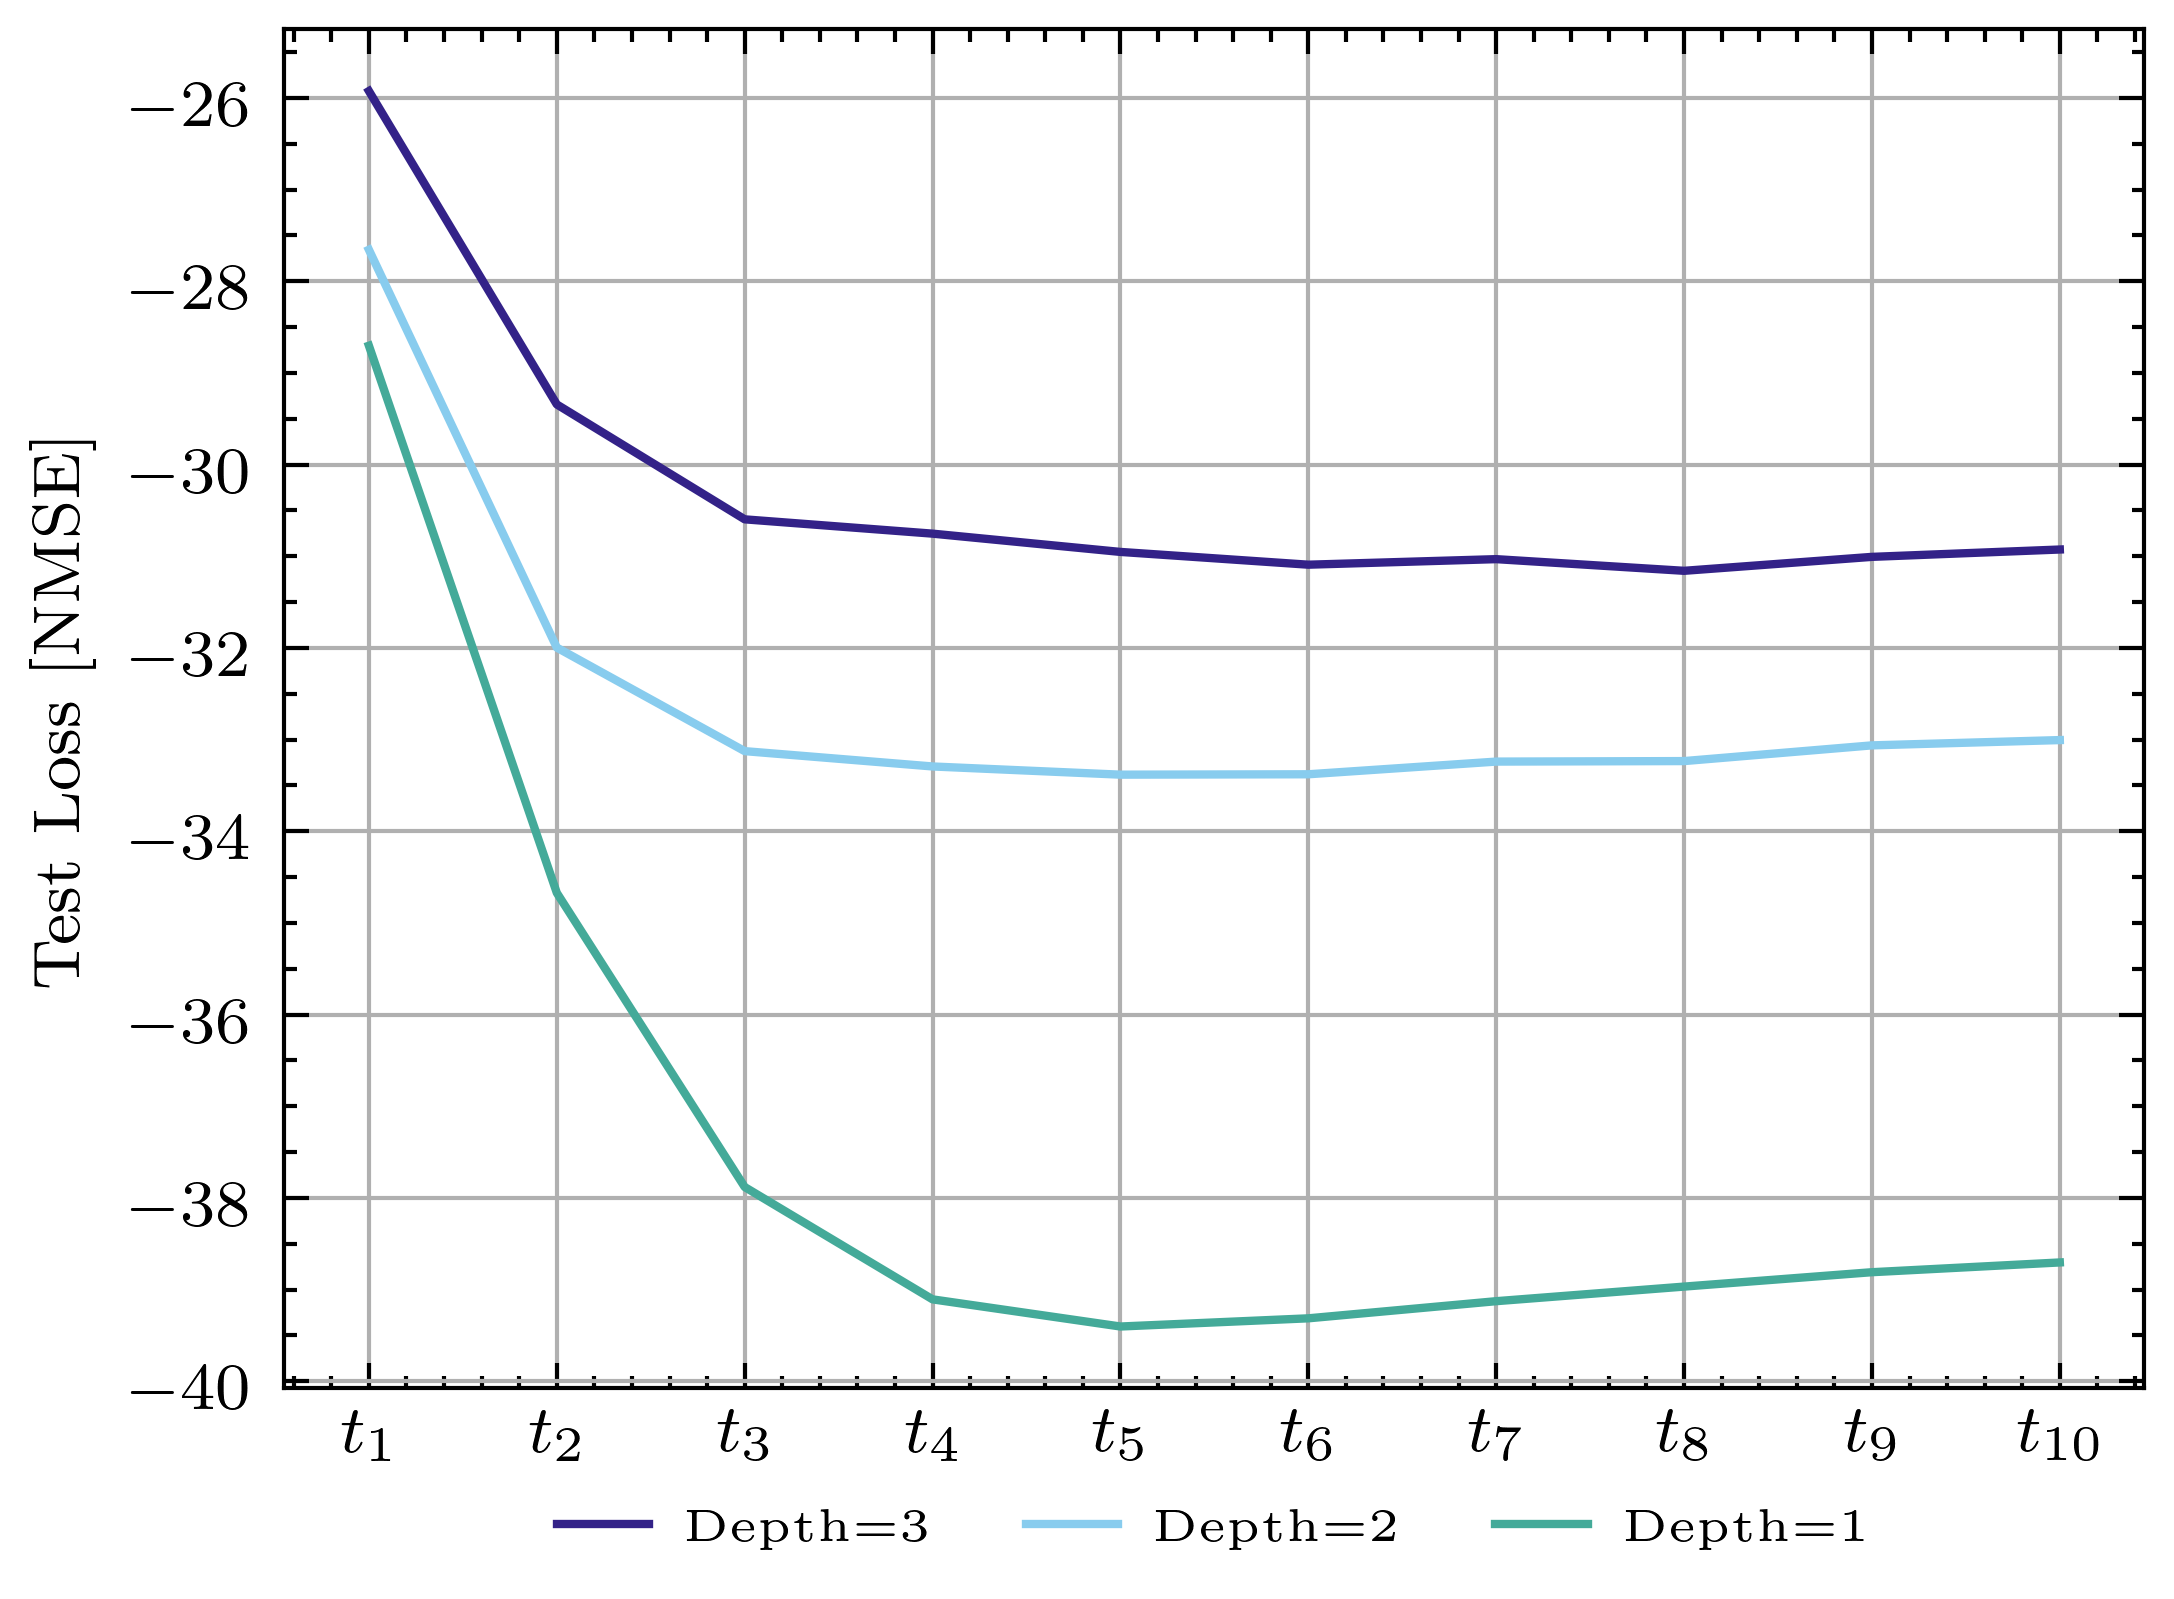

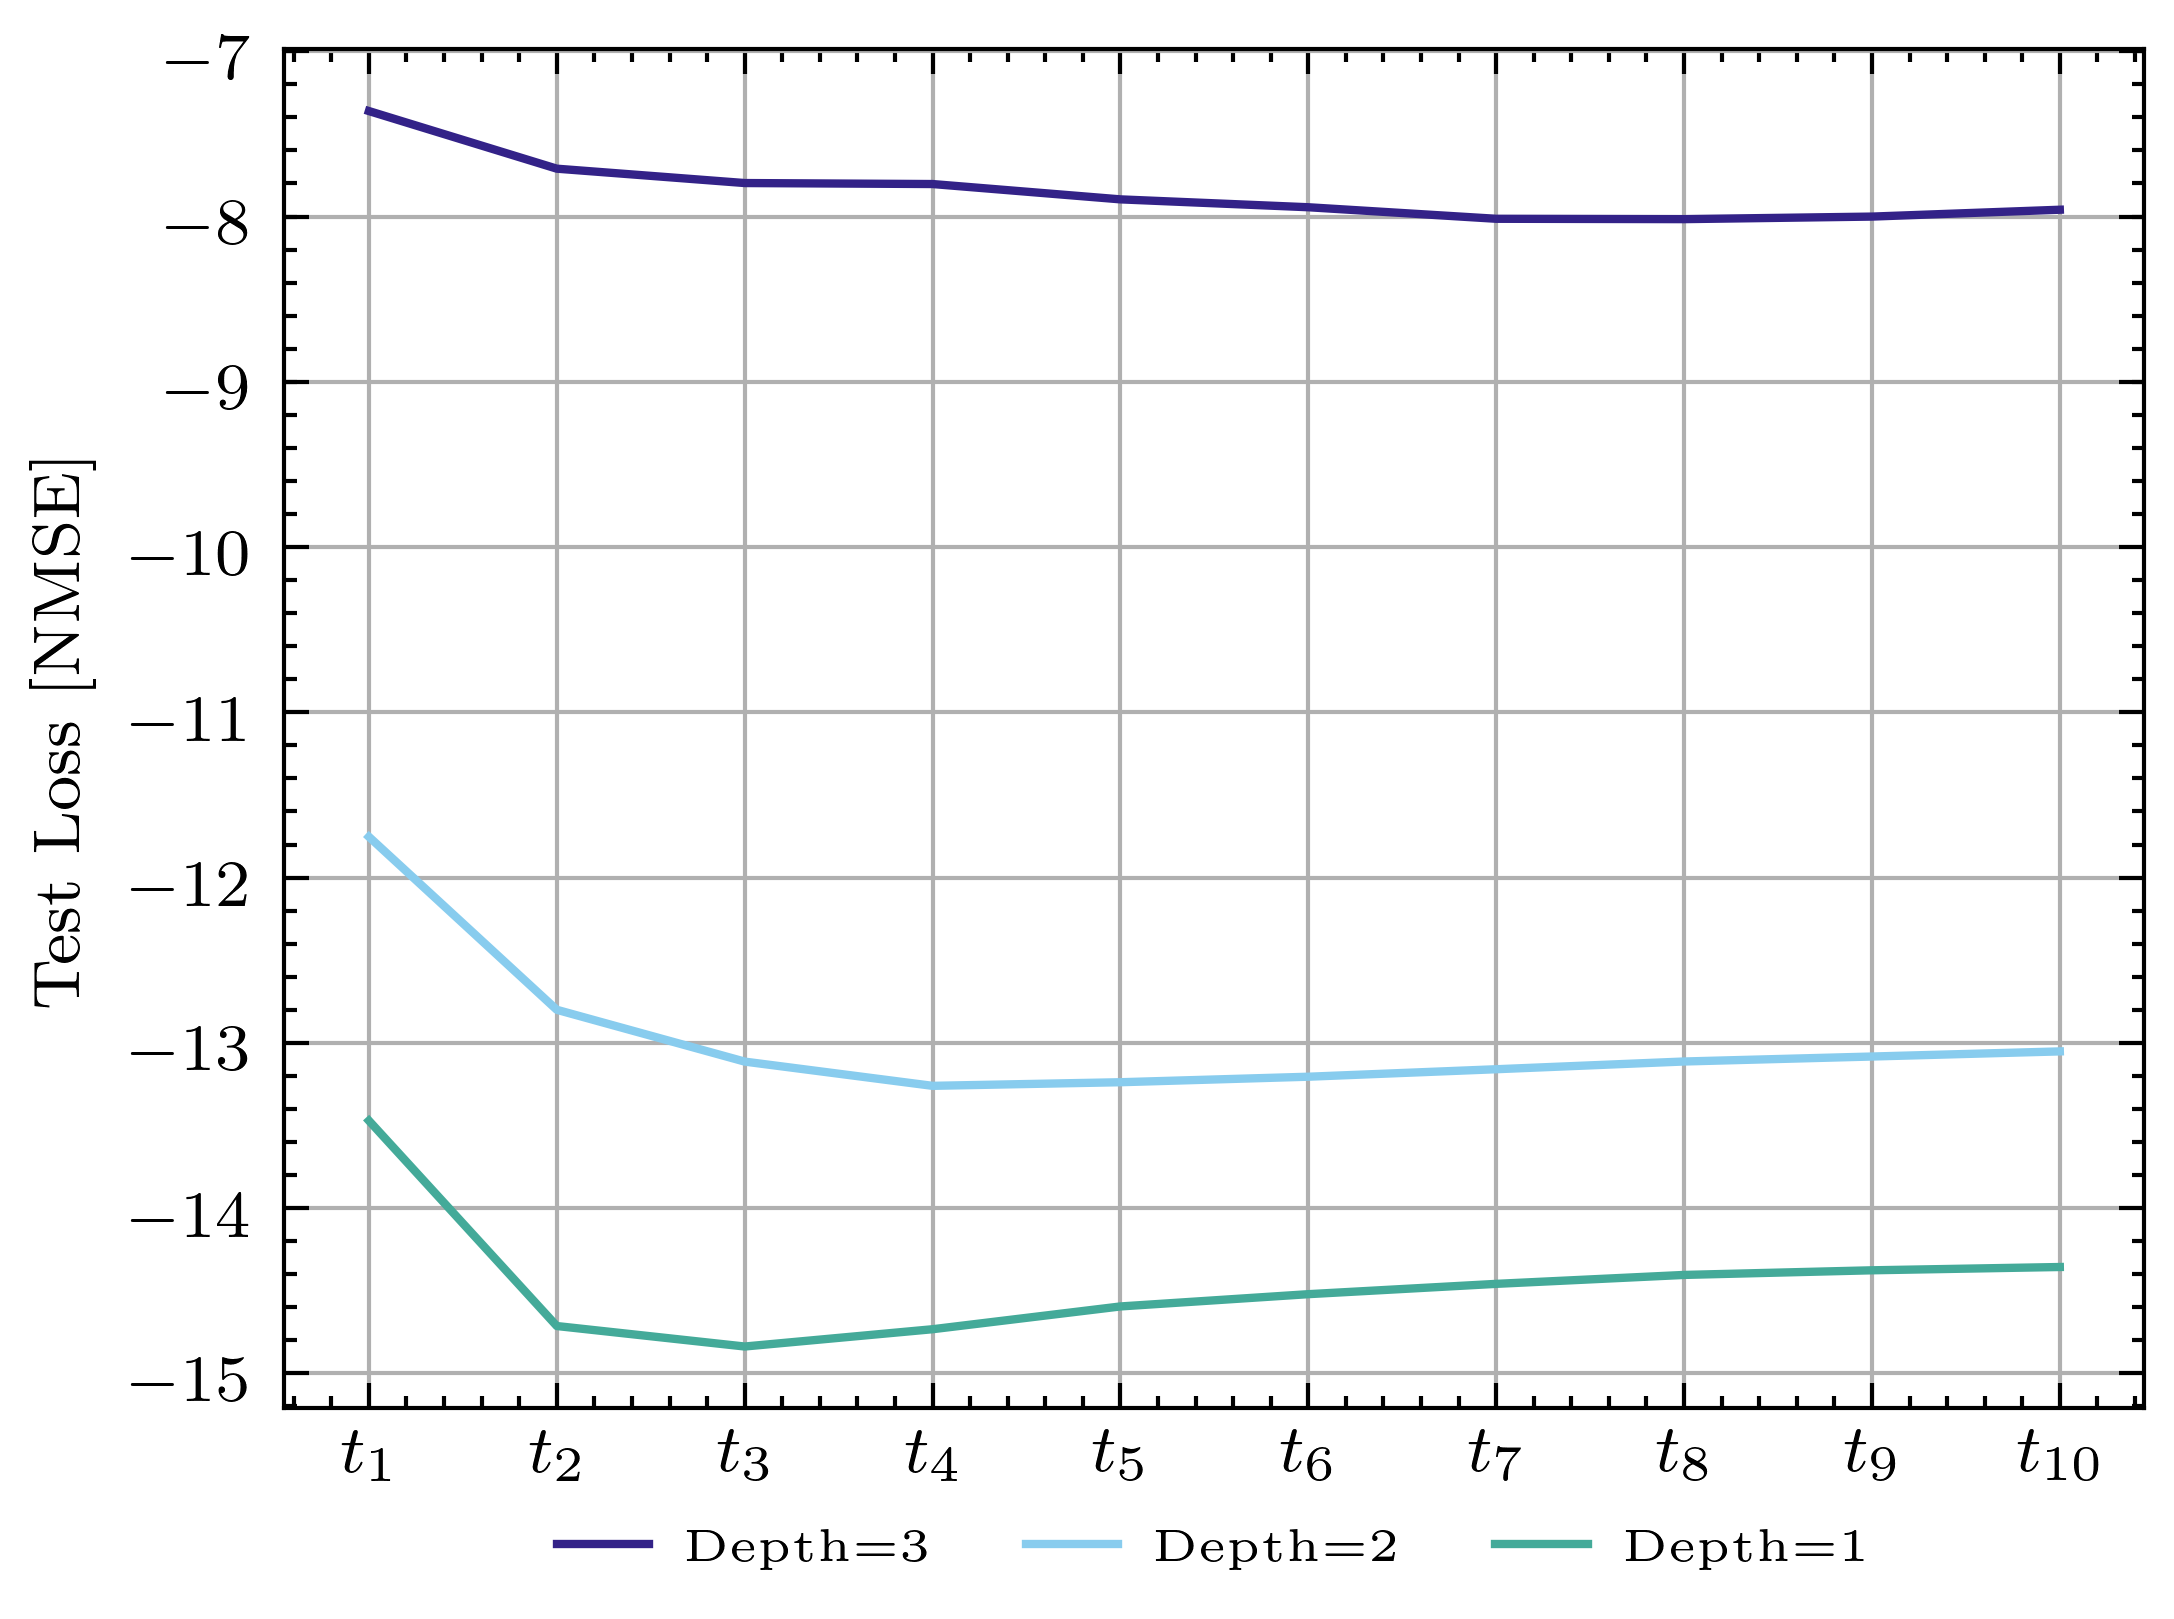

In [80]:
for envir in envirs:
    plot_depth_tests(df,envir,ylabel="Test Loss [NMSE]")